## 引入相关库

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

# Modle
from lightgbm import LGBMRegressor

In [4]:
pd.set_option('display.max_columns', None)
# plt.rcParams['font.sans-serif'] = ['SimHei']

## EDA

### 读取数据集

In [5]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_a.csv')
train.shape, test.shape

((41440, 51), (2469, 50))

In [6]:
train.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,BK00064,1953,0,7,36,0,28,1,1,12,15,16,76,5,3,22,355584000,7411.98,47974.22551,111,810967373,7755,104573.48460,25,264,0,0,0.0,0,0.0,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,BK00049,2007,0,2,184,0,26,0,1,27,5,16,163,6,4,51,5000000,122.83,40706.66775,2,9668955,286,33807.53497,2,4,0,0,0.0,0,0.0,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,BK00050,暂无信息,3,6,60,1,43,2,3,24,35,37,85,6,4,30,1687284798,49071.30,34384.35089,555,344894466,3143,109734.16040,11,159,126,0,0.0,0,0.0,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,BK00051,暂无信息,0,3,364,2,60,1,8,83,30,47,358,3,1,131,468272888,22809.70,20529.55050,260,196307819,6418,30587.07058,58,730,0,1,108037.8,1,108037.8,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,BK00044,暂无信息,1,0,141,0,15,0,0,21,5,10,100,5,2,34,108851470,4463.62,24386.36577,38,286722058,5608,51127.32846,34,851,216,0,0.0,0,0.0,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


### 目标变量

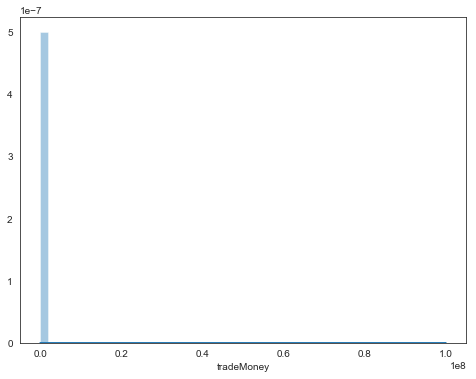

In [7]:
# 查看目标变量分布
sns.set_style('white')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['tradeMoney'])
# ax.set(xlim=(0, 40000))
# g.set(ylim=(0, 1))

In [8]:
# 筛选数据，比较好观察分布
train = train[(train['tradeMoney'] > 500) & (train['tradeMoney'] < 40000)]

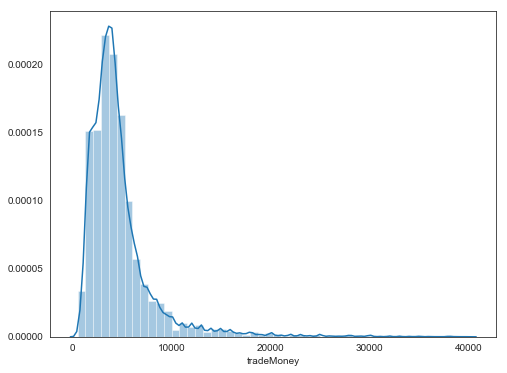

In [9]:
# 查看目标变量分布
# sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['tradeMoney'])

In [10]:
# 查看偏度和峰度
print("Skewness: %f" % train['tradeMoney'].skew())
print("Kurtosis: %f" % train['tradeMoney'].kurt())

Skewness: 3.405891
Kurtosis: 17.501132


### 特征相关

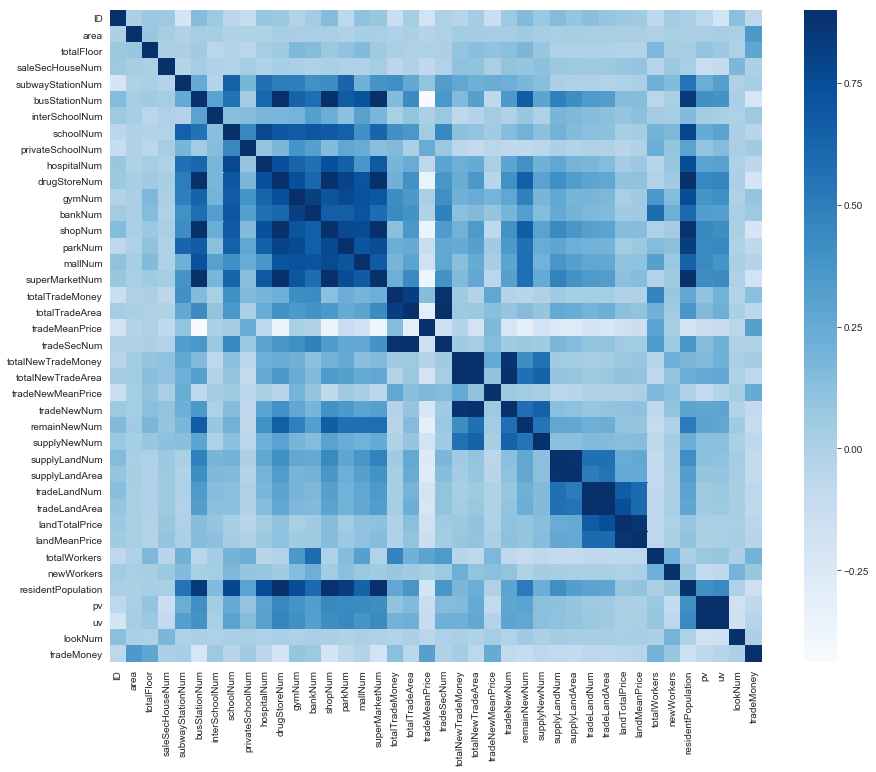

In [11]:
corr = train.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

### 区分特征

In [11]:
# 区分稠密特征和稀疏特征
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# all_feature = train.columns
numeric_feature = []
classified_feature = []

for i in train.columns:
    if i not in ['ID', 'tradeMoney']:
        if train[i].dtype in numeric_dtypes:
            numeric_feature.append(i)
        else:
            classified_feature.append(i)

print('Numeric feature number of %s' % len(numeric_feature))
print('Classified feature number of %s' % len(classified_feature))

Numeric feature number of 38
Classified feature number of 11


### 数值特征分析

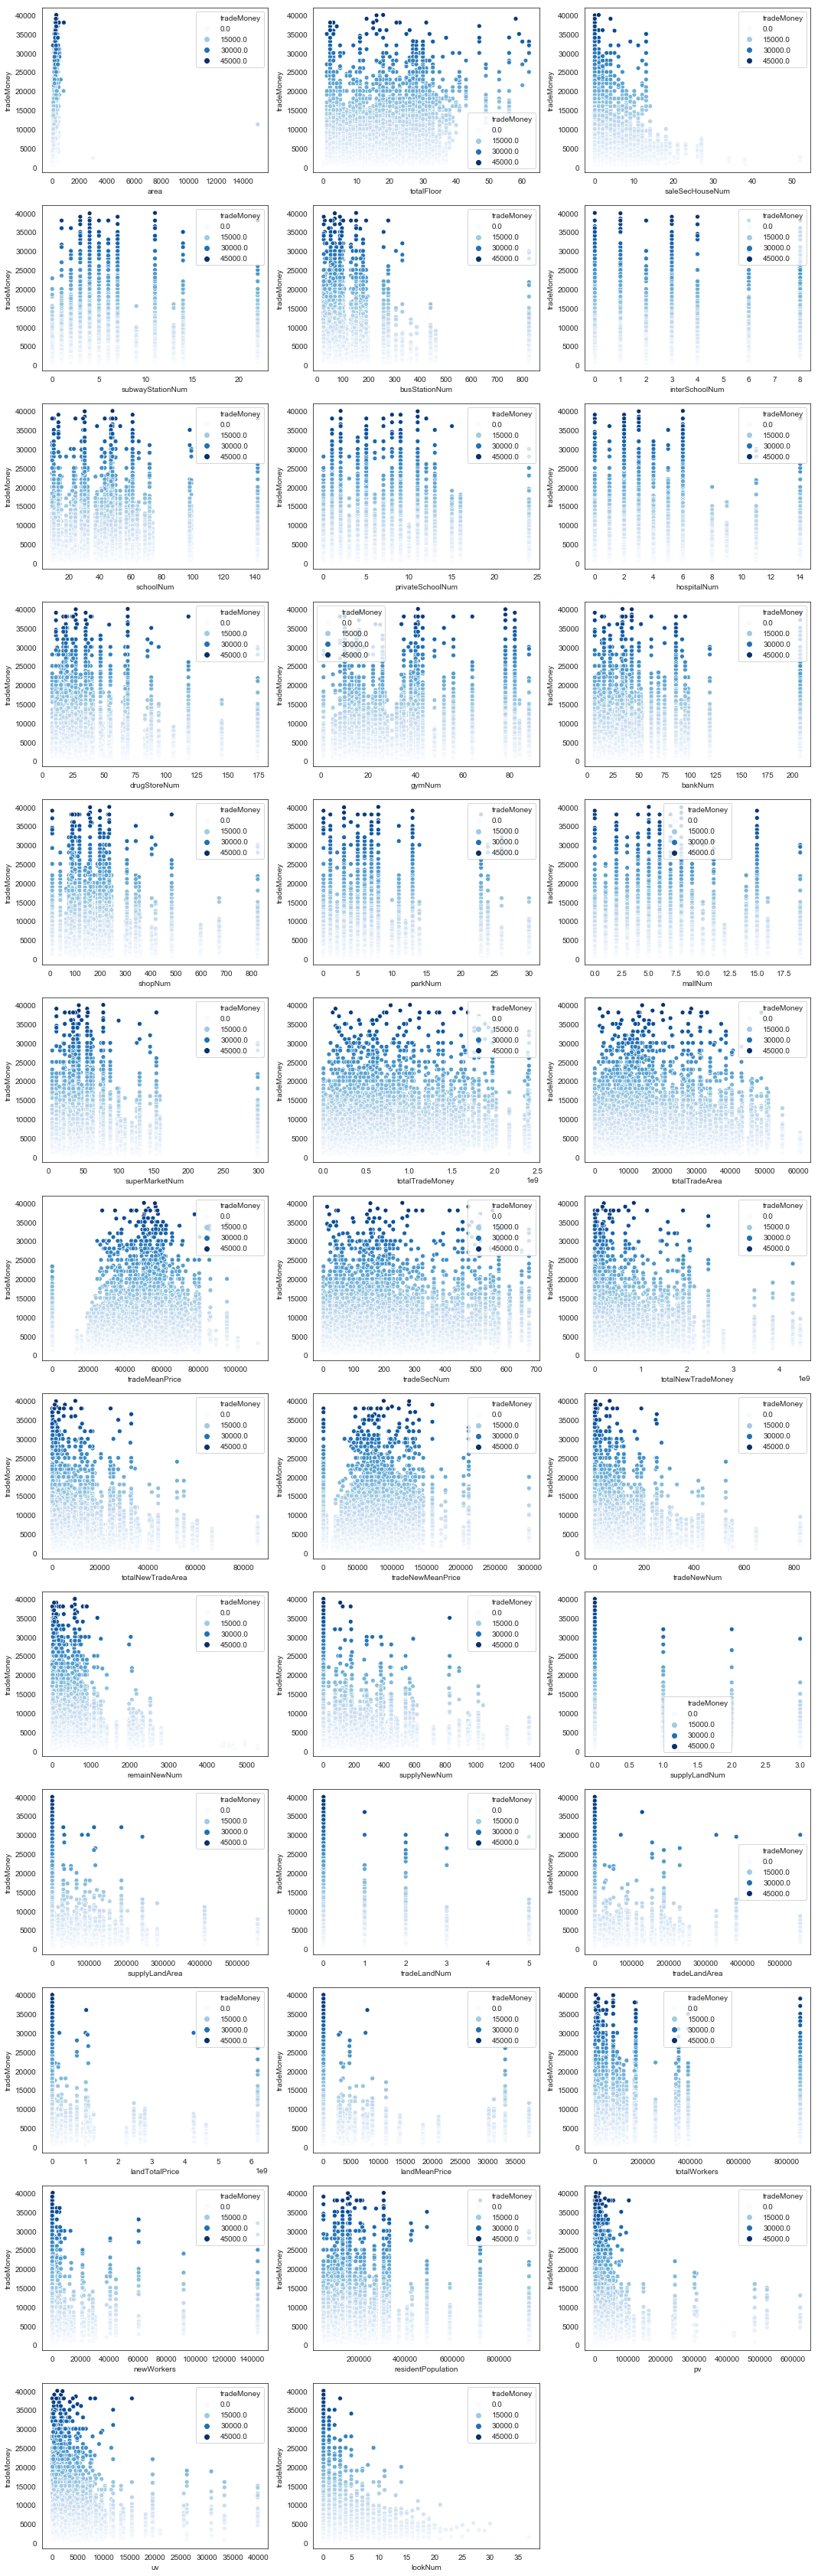

In [14]:
# 绘制稠密特征跟目标变量的散点图
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(18, 180))

for i, feature in enumerate(numeric_feature, 1):
    plt.subplot(len(numeric_feature), 3, i)
    sns.scatterplot(x=feature, y='tradeMoney', hue='tradeMoney', palette='Blues', data=train)

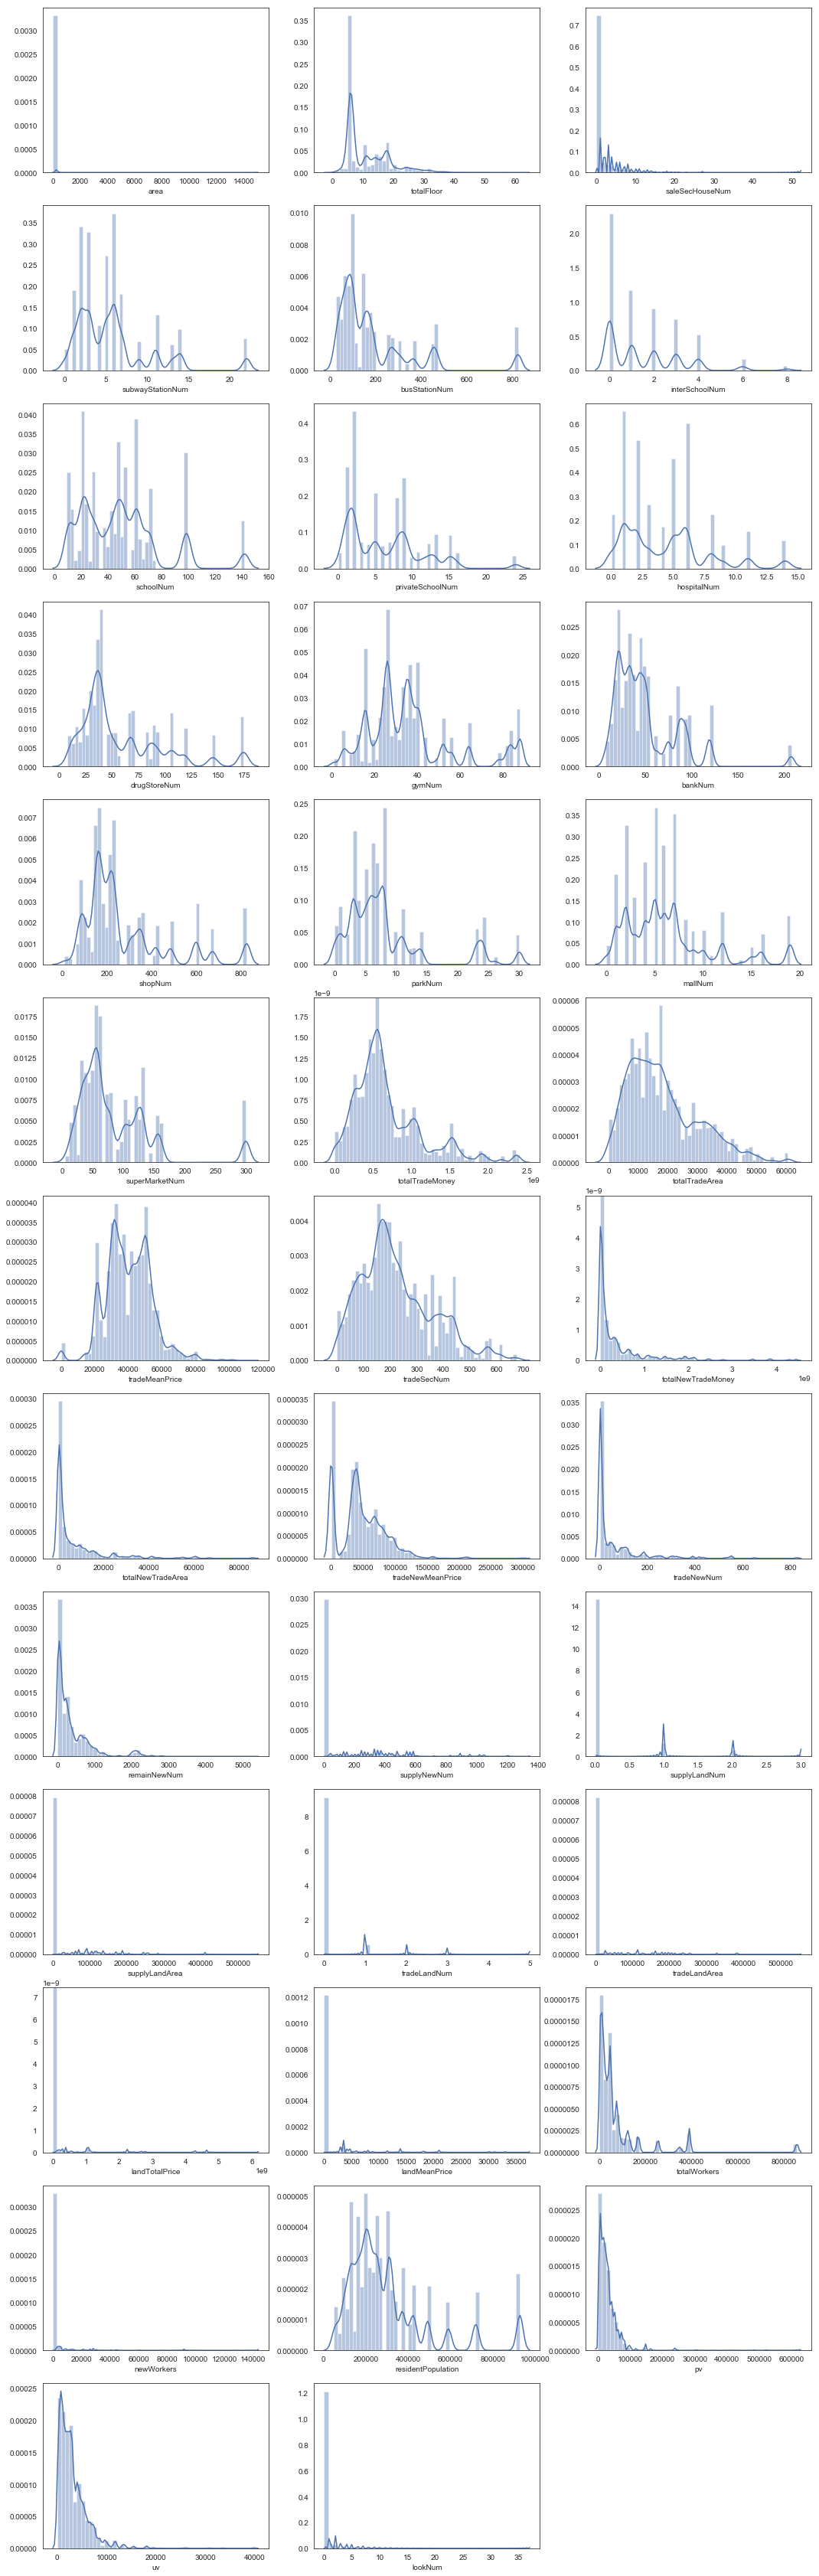

In [15]:
# 绘制数值特征分布图
# sns.set_style('white')
# sns.set_color_codes(palette='deep')
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(18, 180))

for i, feature in enumerate(numeric_feature, 1):
    plt.subplot(len(numeric_feature), 3, i)
    sns.distplot(train[train[feature].notnull()][feature], color='b')

### 分类特征分析

In [17]:
# 查看分类特征
train[classified_feature].head()

,rentType,houseType,houseFloor,houseToward,houseDecoration,communityName,city,region,plate,buildYear,tradeTime
0,未知方式,2室1厅1卫,低,暂无数据,其他,XQ00051,SH,RG00001,BK00064,1953,2018/11/28
1,未知方式,3室2厅2卫,中,暂无数据,简装,XQ00130,SH,RG00002,BK00049,2007,2018/12/16
2,未知方式,3室2厅2卫,低,暂无数据,其他,XQ00179,SH,RG00002,BK00050,暂无信息,2018/12/22
3,未知方式,1室1厅1卫,中,暂无数据,精装,XQ00313,SH,RG00002,BK00051,暂无信息,2018/12/21
4,未知方式,3室2厅3卫,低,暂无数据,毛坯,XQ01257,SH,RG00003,BK00044,暂无信息,2018/11/18


In [18]:
# 分析分类特征的除重值个数
for i in classified_feature:
    print("{:<16}: {:>6} {:>6}".format(i, train[i].nunique(), test[i].nunique()))

rentType        :      4      3
houseType       :     99     31
houseFloor      :      3      3
houseToward     :     10      8
houseDecoration :      4      4
communityName   :   4208   2469
city            :      1      1
region          :     15     14
plate           :     66     63
buildYear       :     80     67
tradeTime       :    361    331


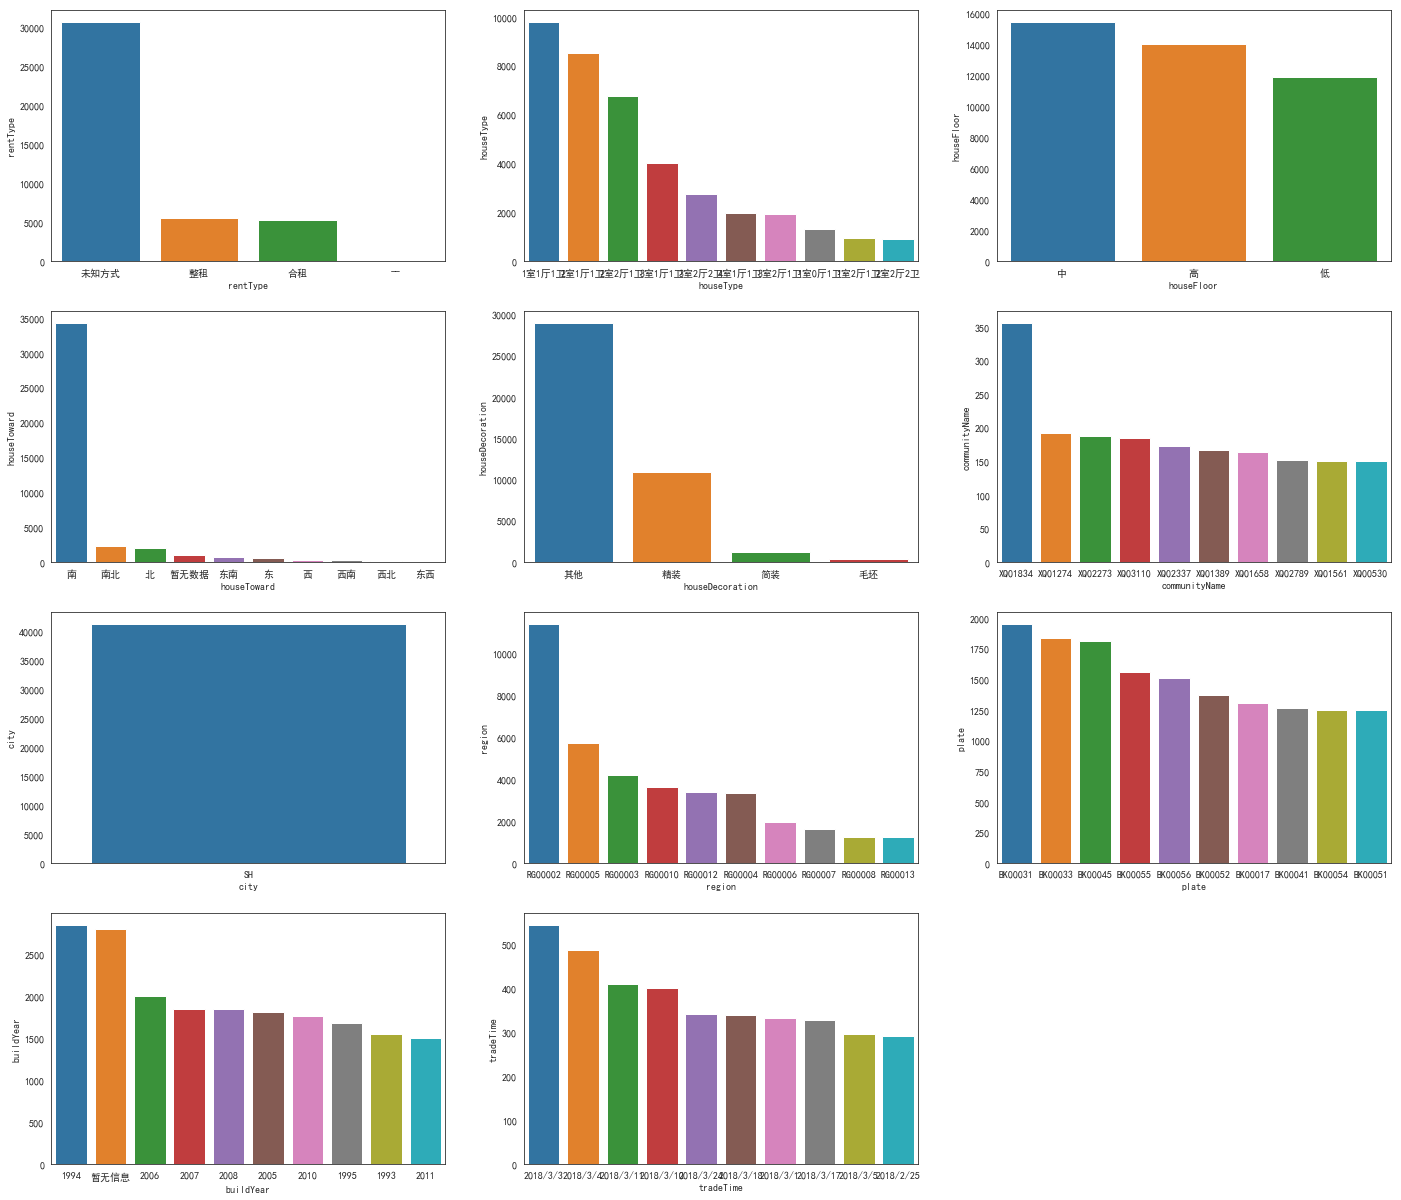

In [19]:
# 绘制分类特征分布图，只取最多的10个
f, ax = plt.subplots(ncols=3, nrows=0, figsize=(24, 60))

for i, feature in enumerate(classified_feature, 1):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.subplot(len(classified_feature), 3, i)
    df = train[feature].value_counts()[:10].reset_index()
    sns.barplot(x='index', y=feature, data=df)
    plt.xlabel(feature)

### 缺失值分析

In [12]:
# 计算缺失值百分比
def percent_missing(df):
    dict_percent = {}
    cols = df.columns
    for i in cols:
        dict_percent.update({i:round(df[i].isnull().mean()*100, 2)})
    return sorted(dict_percent.items(), key=lambda x: x[1], reverse=True)[0:10]

In [13]:
percent_missing(train)

[('pv', 0.04),
 ('uv', 0.04),
 ('ID', 0.0),
 ('area', 0.0),
 ('rentType', 0.0),
 ('houseType', 0.0),
 ('houseFloor', 0.0),
 ('totalFloor', 0.0),
 ('houseToward', 0.0),
 ('houseDecoration', 0.0)]

In [14]:
percent_missing(test)

[('pv', 0.08),
 ('uv', 0.08),
 ('ID', 0.0),
 ('area', 0.0),
 ('rentType', 0.0),
 ('houseType', 0.0),
 ('houseFloor', 0.0),
 ('totalFloor', 0.0),
 ('houseToward', 0.0),
 ('houseDecoration', 0.0)]

## 数据预处理

缺失值分析
采取合适的方式对缺失值进行填充

异常值处理(根据测试集数据的分布处理训练集的数据分布)
使用合适的方法找出异常值
对异常值进行处理

深度清洗
分析每一个communityName、city、region、plate的数据分布并对其进行数据清洗

### 异常值清洗

In [15]:
# 根据训练集和测试集的分布进行判断
train = train[(train['area'] < 200) & (train['saleSecHouseNum'] < 20) & (train['remainNewNum'] < 3000) & (train['lookNum'] < 20)]

In [16]:
train.shape, test.shape

((40510, 51), (2469, 50))

In [17]:
# 数据集筛选完后先删除不用的特征
train_ID = train['ID']
train.drop(['ID'], axis=1, inplace=True)
test_ID = test['ID']
test.drop(['ID'], axis=1, inplace=True)

### 目标特征转换

In [18]:
train['tradeMoney'] = np.log1p(train['tradeMoney'])

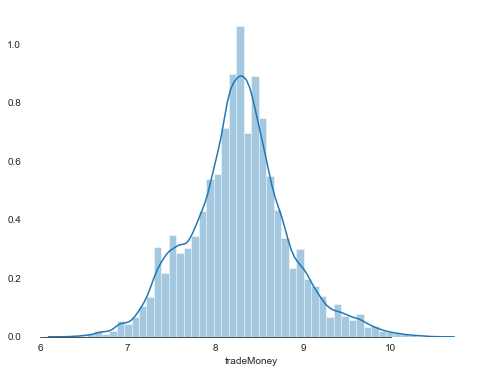

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['tradeMoney'])
sns.despine(trim=True, left=True)

In [20]:
# 查看偏度和峰度
print("Skewness: %f" % train['tradeMoney'].skew())
print("Kurtosis: %f" % train['tradeMoney'].kurt())

Skewness: 0.167024
Kurtosis: 0.487854


In [21]:
# 分割特征和目标标签
target = train['tradeMoney']
train.drop(['tradeMoney'], axis=1, inplace=True)

In [22]:
# 合并数据集
data = pd.concat([train, test], sort=False).reset_index(drop=True)

### 缺失值处理

In [23]:
# 用中位数填充缺失值
data['pv'] = data['pv'].fillna(data['pv'].median())
data['uv'] = data['uv'].fillna(data['uv'].median())

In [24]:
percent_missing(data)

[('area', 0.0),
 ('rentType', 0.0),
 ('houseType', 0.0),
 ('houseFloor', 0.0),
 ('totalFloor', 0.0),
 ('houseToward', 0.0),
 ('houseDecoration', 0.0),
 ('communityName', 0.0),
 ('city', 0.0),
 ('region', 0.0)]

## 特征工程

### 特征处理

In [25]:
data['rentType'] = data['rentType'].str.replace('--', '未知方式')

In [26]:
data['buildYear'] = np.where(data['buildYear'] == '暂无信息', 2019, data['buildYear'])
data['buildYear'] = data['buildYear'].astype(int)
data['buildYear'] = 2019-data['buildYear']

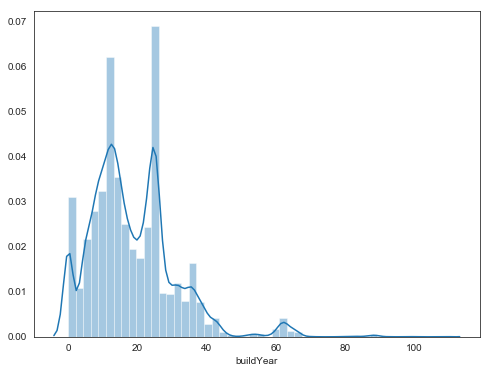

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(data['buildYear'])

In [28]:
# 转日期格式，并查看最早的年份
data['tradeTime'] = pd.to_datetime(data['tradeTime'])
data['tradeTime'].map(lambda x: str(x)[:4]).value_counts()

2018    42979
Name: tradeTime, dtype: int64

In [29]:
# 计算天数
data['tradeDay'] = (pd.to_datetime('2019-01-01') - data['tradeTime']).dt.days

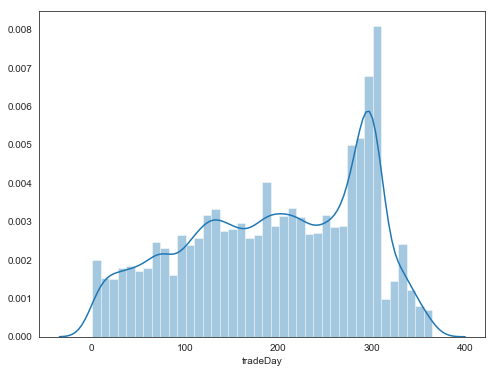

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(data['tradeDay'])

In [31]:
# 先查看下是否等长度
data['houseType'].map(lambda x: len(x)).value_counts()

6    42979
Name: houseType, dtype: int64

In [32]:
data['houseType1'] = data['houseType'].map(lambda x: int(x[0]))
data['houseType2'] = data['houseType'].map(lambda x: int(x[2]))
data['houseType3'] = data['houseType'].map(lambda x: int(x[4]))

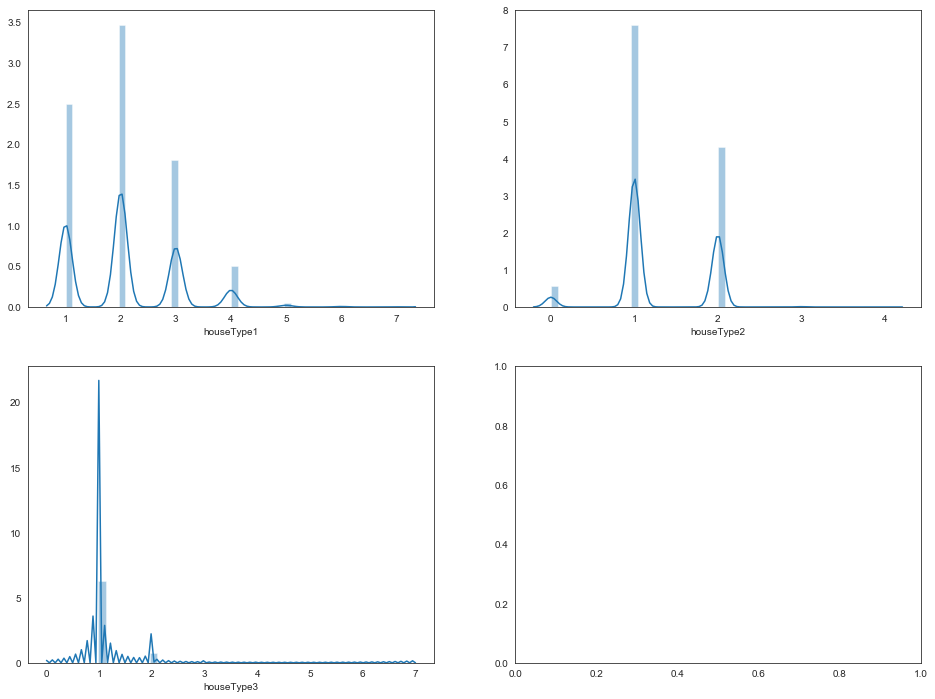

In [33]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
sns.distplot(data['houseType1'], ax=axs[0, 0])
sns.distplot(data['houseType2'], ax=axs[0, 1])
sns.distplot(data['houseType3'], ax=axs[1, 0])

### 倾斜特征处理

In [34]:
numeric = []
for i in data.columns:
    if data[i].dtype in numeric_dtypes:
        numeric.append(i)

In [35]:
# numeric

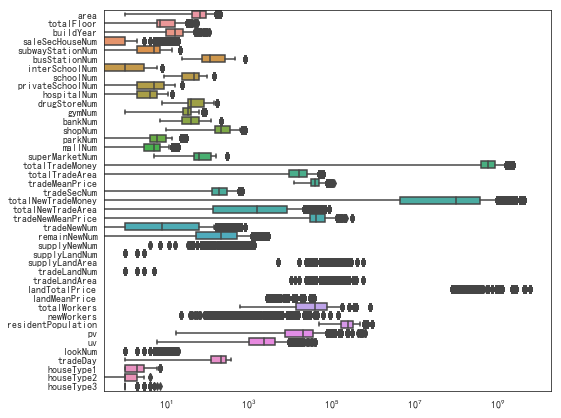

In [44]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale('log')
sns.boxplot(data=data[numeric], orient='h')

In [36]:
skew_features = data[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 40 numerical features with Skew > 0.5 :


newWorkers        12.697860
landTotalPrice     7.252086
landMeanPrice      6.872847
pv                 6.406081
lookNum            5.827831
tradeLandNum       5.059473
tradeLandArea      5.032642
supplyLandArea     4.792817
totalWorkers       3.865482
supplyLandNum      3.290741
dtype: float64

In [37]:
for i in skew_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))

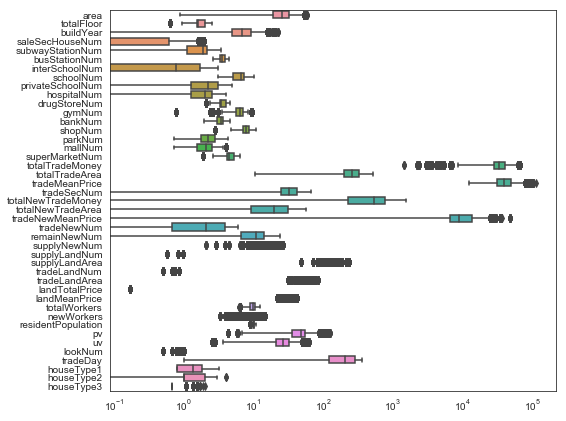

In [38]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale('log')
sns.boxplot(data=data[numeric], orient='h')

## 特征选择

In [39]:
# 清除不需要的特征，保留ID做查询
data.drop(['communityName', 'houseType', 'city', 'tradeTime'], axis=1, inplace=True)

In [40]:
numeric_feature = []
classified_feature = []

for i in data.columns:
    if i not in ['ID', 'tradeMoney']:
        if data[i].dtype in numeric_dtypes:
            numeric_feature.append(i)
        else:
            classified_feature.append(i)

print('Numeric feature number of %s' % len(numeric_feature))
print('Classified feature number of %s' % len(classified_feature))

Numeric feature number of 43
Classified feature number of 6


In [41]:
numeric_feature

['area',
 'totalFloor',
 'buildYear',
 'saleSecHouseNum',
 'subwayStationNum',
 'busStationNum',
 'interSchoolNum',
 'schoolNum',
 'privateSchoolNum',
 'hospitalNum',
 'drugStoreNum',
 'gymNum',
 'bankNum',
 'shopNum',
 'parkNum',
 'mallNum',
 'superMarketNum',
 'totalTradeMoney',
 'totalTradeArea',
 'tradeMeanPrice',
 'tradeSecNum',
 'totalNewTradeMoney',
 'totalNewTradeArea',
 'tradeNewMeanPrice',
 'tradeNewNum',
 'remainNewNum',
 'supplyNewNum',
 'supplyLandNum',
 'supplyLandArea',
 'tradeLandNum',
 'tradeLandArea',
 'landTotalPrice',
 'landMeanPrice',
 'totalWorkers',
 'newWorkers',
 'residentPopulation',
 'pv',
 'uv',
 'lookNum',
 'tradeDay',
 'houseType1',
 'houseType2',
 'houseType3']

In [42]:
data[classified_feature].head()

,rentType,houseFloor,houseToward,houseDecoration,region,plate
0,未知方式,低,暂无数据,其他,RG00001,BK00064
1,未知方式,中,暂无数据,简装,RG00002,BK00049
2,未知方式,低,暂无数据,其他,RG00002,BK00050
3,未知方式,中,暂无数据,精装,RG00002,BK00051
4,未知方式,低,暂无数据,毛坯,RG00003,BK00044


In [43]:
train_data = pd.get_dummies(data).reset_index()

In [44]:
train_data.shape

(42979, 144)

In [45]:
train_X = train_data.iloc[:len(target), :]
test_X = train_data.iloc[len(target):, :]
train_X.shape, test_X.shape

((40510, 144), (2469, 144))

## 创建模型

In [46]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [47]:
kf = KFold(n_splits=5, random_state=12, shuffle=True)

In [48]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cv_rmse(model, X=train_X):
    rmse = np.sqrt(-cross_val_score(model, X, target, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [49]:
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [77]:
# LGBMRegressor?

In [52]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.2015 (0.0046)


In [50]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))


D:\Program Files\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Program Files\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:23:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Program Files\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Program Files\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Program Files\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:36:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost: 0.2000 (0.0045)


NameError: name 'scores' is not defined

In [53]:
scores['xgb'] = (score.mean(), score.std())

In [54]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.2222 (0.0046)


In [55]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.88241e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.78261e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.74203e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.76166e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.23527e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\li

D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.81048e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.80987e-17): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.76559e-17): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.83159e-17): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.7653e-17): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\lin

ridge: 0.2237 (0.0041)


In [56]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1997 (0.0049)


In [57]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1990 (0.0047)


In [60]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(train_X), np.array(target))

stack_gen
[15:40:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:54:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:59:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.88168e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.22056e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.78184e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.91574e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.79547e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\li

D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.79555e-17): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.85836e-17): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.81052e-17): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.83207e-17): result may not be accurate.
  overwrite_a=True).T


[17:34:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:41:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.01897e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.01485e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.59562e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.16283e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.97734e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\li

In [61]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(train_X, target)

lightgbm


In [63]:
print('xgboost')
xgb_model_full_data = xgboost.fit(train_X, target)

xgboost
[18:10:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

D:\Program Files\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Program Files\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [64]:
print('Svr')
svr_model_full_data = svr.fit(train_X, target)

Svr


In [65]:
print('Ridge')
ridge_model_full_data = ridge.fit(train_X, target)

Ridge


D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.01897e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.01485e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.59562e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.16283e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.97734e-19): result may not be accurate.
  overwrite_a=True).T
D:\Program Files\Anaconda3\lib\site-packages\sklearn\li

In [66]:
print('RandomForest')
rf_model_full_data = rf.fit(train_X, target)

RandomForest


In [67]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(train_X, target)

GradientBoosting


In [83]:
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))
# Get final precitions from the blended model
blended_score = rmsle(target, blended_predictions(train_X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.18014285412070252


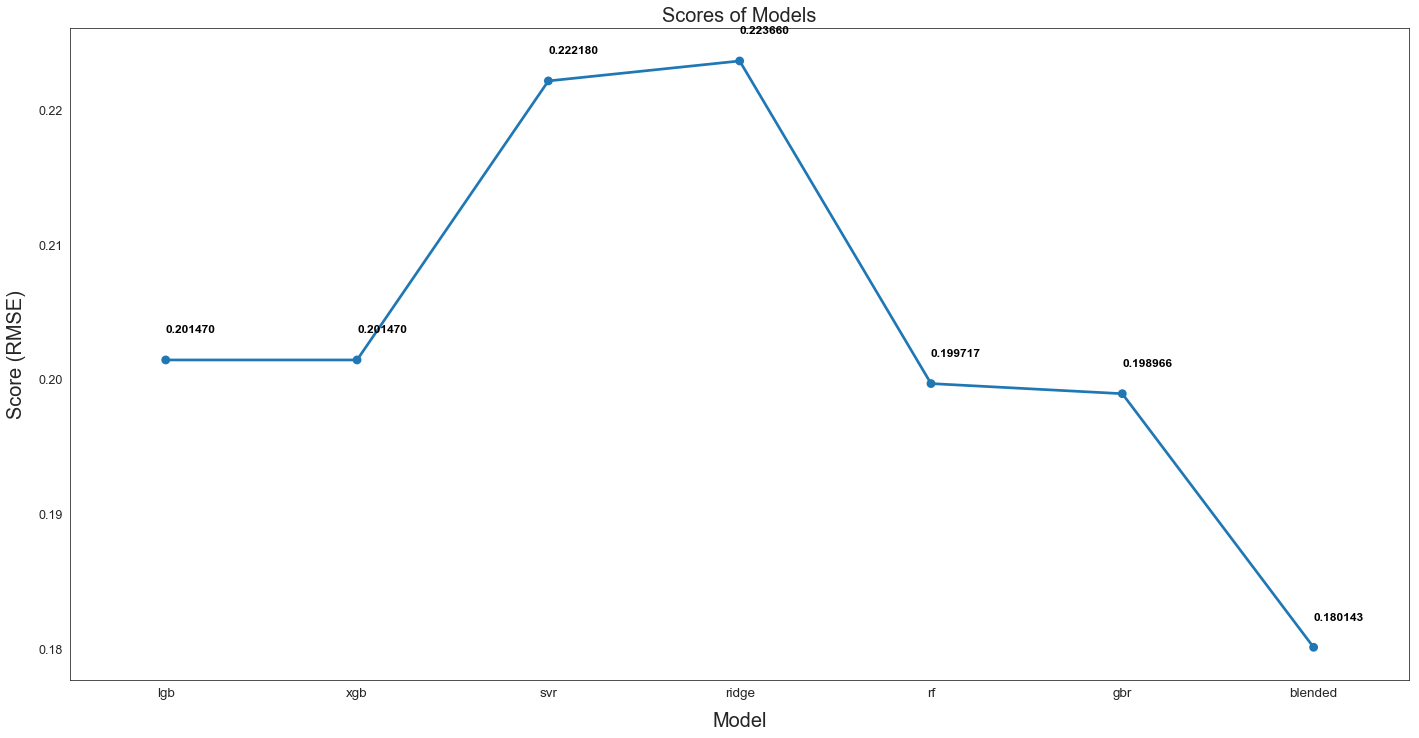

In [84]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [85]:
submission = np.floor(np.expm1(blended_predictions(test_X)))

In [86]:
len(submission)

2469

In [87]:
# pd.read_csv('sub_a_913.txt')

In [88]:
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))
    # a榜测分
    conmbine1 = pd.read_csv("sub_a_913.txt",engine = "python")
    score1 = r2_score(pred, conmbine1)
    # b榜测分
#     conmbine3 = pd.read_csv("D:/城市-房产租金预测/best_result/sub_b_9194.csv",engine = "python",header=None)
#     score3= r2_score(pred, conmbine3)
    print("对比919分数:{}".format(score1))


In [89]:
online_score(submission)

预测结果最大值：16241.0,预测结果最小值：1221.0
对比919分数:0.9274529871403266
